In [1]:
import bet.sample as sample
import bet.sampling.basicSampling as bsam
import bet.calculateP.simpleFunP as sfnP
import numpy as np
import scipy.stats as sstats

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [304]:
# plt.rcParams['figure.figsize'] = 5,5
plt.rcParams['font.size'] = 24
# font sizes for labels and legends
fsize_legend = 16
fsize_label = 24

In [305]:
dimension = 2
numSamples = 1000
# MC assumption on volumes
MC_assumption = False

In [306]:
I = np.eye(dimension)
def model(input_samples):
        return (I@input_samples.T).T
sampler = bsam.sampler(model)

In [307]:
# default random sample set is uniform over unit domain (normalized space)
input_set = input_samples = bsam.random_sample_set('r',input_obj=dimension, num_samples=numSamples)
param_ref = np.array([0.5, 0.5])
input_set.set_reference_value(param_ref)

# Estimate volumes of Voronoi cells associated with the parameter samples
if MC_assumption is False:
    input_samples.estimate_volume(n_mc_points=5E4)
else:
    input_samples.estimate_volume_mc()

# input_set = bsam.regular_sample_set(input_obj=dimension, num_samples_per_dim=49)
disc = sampler.compute_QoI_and_create_discretization(input_sample_set=input_set)
Qref = disc.get_output().get_reference_value()
print('Reference Value:', param_ref, 'maps to', Qref)

Reference Value: [0.5 0.5] maps to [0.5 0.5]


# Plotting


In [316]:
def plot_2d_comparison(xi, yi, left, right,
                       left_label='Approx', right_label='Exact'):
    lambda_mesh = np.vstack([xi.flatten(),yi.flatten()]).T
    if left.get_input().get_probabilities() is None:
        zi_left = left.updated_pdf(lambda_mesh)
    else:
        pdf_left = left.get_input().get_probabilities()/left.get_input().get_volumes()
        zi_left = pdf_left[left.get_input().query(lambda_mesh)[1]]

    if right.get_input().get_probabilities() is None:
        zi_right = right.updated_pdf(lambda_mesh)
    else:
        pdf_right = right.get_input().get_probabilities()/right.get_input().get_volumes()
        zi_right = pdf_right[right.get_input().query(lambda_mesh)[1]]
    max_ht = 30
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), sharey=True)
    # axes[0].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.viridis)
    a00 = axes[0].contourf(xi, yi, zi_left.reshape(xi.shape), vmin=0, vmax=max_ht)
    # axes[1].pcolormesh(xi, yi, zi_a.reshape(xi.shape), shading='gouraud', cmap=plt.cm.viridis)
    a11 = axes[1].contourf(xi, yi, zi_right.reshape(xi.shape), vmin=0, vmax=max_ht)
    axes[0].set_ylabel('$\lambda_2$')
    axes[1].set_xlabel('$\lambda_1$')
    axes[0].set_xlabel('$\lambda_1$')

    axes[0].annotate(left_label, (0.3, 0.7), fontsize=fsize_legend*1.5, c='w')
    axes[1].annotate(right_label, (0.3, 0.7), fontsize=fsize_legend*1.5, c='w')
    axes[0].axis('equal')
    axes[1].axis('equal')
    # fig.colorbar(a00, ax=axes[0])
    # fig.colorbar(a11, ax=axes[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.825, 0.125, 0.025, 0.75])
    fig.colorbar(a00, cax=cbar_ax)
    # plt.tight_layout()
    savename = '%s_N%d-vs-%s_N%d.pdf'%(left_label, left.check_nums(), right_label, right.check_nums())
    savename = savename.replace('$','').replace('=','').replace(',','-').replace(' ','')
    plt.savefig(savename, bbox_inches='tight')
    plt.show()

def udpated_pdf_conditional_comparison(disc, num=100,
                                    condition_on=0.5,
                                    label='approx',
                                    fsize_label=24,
                                    fsize_legend=16):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    num = 100
    input_values_plotting = np.linspace(0.25,0.75,num)
    # condition_on = 0.5
    conditional = np.ones(num)*condition_on
    condX = np.column_stack((conditional, input_values_plotting))
    condY = np.column_stack((input_values_plotting, conditional))
    ax.plot(input_values_plotting, 
            disc.updated_pdf(condX),
            ls='-', lw=7,
            label='${\hat{\pi}^{up}(\lambda\, |\, \lambda_2=%1.2f)}$'%condition_on)
    ax.plot(input_values_plotting,
            disc.updated_pdf(condY),
            ls='--', lw=5,
            label='${\hat{\pi}^{up}(\lambda\, |\, \lambda_1=%1.2f)}$'%condition_on)
    plt.hlines(25,0.4,0.6, label='Analytical', lw=3, zorder=3)
    plt.legend(loc=10, fontsize=fsize_legend)
    plt.xlabel('$\lambda_i$',fontsize=fsize_label)
    plt.savefig('identity_1d_conditionals_%dE-2_N%d_%s.pdf'%(100*condition_on, disc.check_nums(), label),
                bbox_inches='tight')
    plt.show()

---
# Set-Based Approach

In [309]:
import bet.calculateP.simpleFunP as simpleFunP
import bet.calculateP.calculateP as calculateP

In [310]:
disc_1 = disc.copy()
simpleFunP.regular_partition_uniform_distribution_rectangle_size(
        data_set=disc_1, Q_ref=Qref, rect_size=0.2,
        cells_per_dimension = 1)
calculateP.prob(disc_1)

In [311]:
# For comparison's sake, we will also show 
# the impact of discretizing the output space
disc_2 = disc.copy()
simpleFunP.regular_partition_uniform_distribution_rectangle_size(
        data_set=disc_2, Q_ref=Qref, rect_size=0.2,
        cells_per_dimension = 2)
calculateP.prob(disc_2)

In [312]:
# pdf_1 = disc_1.get_input().get_probabilities()/disc_1.get_input().get_volumes()
# pdf_2 = disc_2.get_input().get_probabilities()/disc_2.get_input().get_volumes()

## Plotting

In [313]:
x, y = input_set._values.T
nbins = 50
xmn, xmx = 0.25, 0.75
ymn, ymx = 0.25, 0.75
xi, yi = np.mgrid[xmn:xmx:nbins*1j, ymn:ymx:nbins*1j]
lambda_mesh = np.vstack([xi.flatten(),yi.flatten()]).T

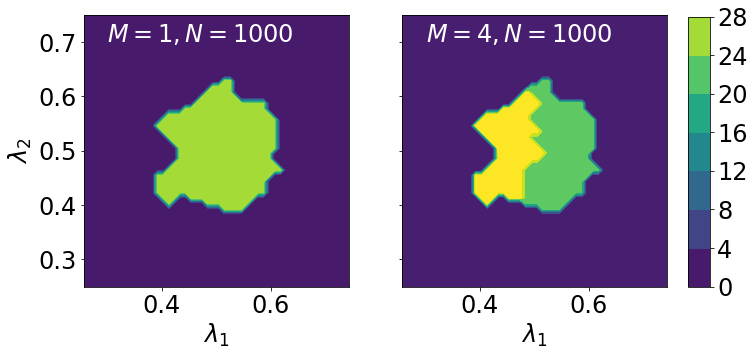

In [317]:
plot_2d_comparison(xi, yi, disc_1, disc_2,
                   '$M=1, N=%d$'%(numSamples),
                   '$M=4, N=%d$'%(numSamples))

---
# Sample-Based Approach

In [181]:
# set distributions analytically.
disc.set_initial(dist=sstats.uniform, loc=0, scale=1, gen=False)
disc.set_observed(dist=sstats.uniform, loc=0.4, scale=0.2)
# disc.compute_pushforward()
# to see the impact of kernel density approximation, omit the following:
# disc.set_predicted(dist=sstats.uniform, loc=0, scale=1)
updated_pdf = disc.updated_pdf()

## Plotting

## 1D conditional Plots

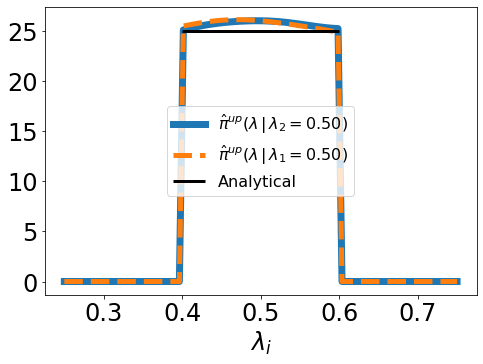

In [210]:
udpated_pdf_conditional_comparison(disc_c, num=100,
                                condition_on=0.5,
                                label='approx')

## Analytical Predicted Distribution = No Error in Updated Distribution

We can use `BET`'s functionality to compute the updated density using analytical functions for all three components of the problem: initial, observed, and predicted.

By creating a copy of our `discretization` object, we can edit our assumptions without affecting the instance we just created.

In [184]:
disc_a = disc.copy()
disc_a.get_input()._densities = None
# disc_a.set_initial(num=int(1E3), gen=True)
disc_a.set_predicted(dist=sstats.uniform, loc=0, scale=1)
updated_pdf_a = disc_a.updated_pdf()

In [196]:
disc_b = disc.copy()
disc_b.get_input()._densities = None
disc_b.set_initial(num=int(1E3), gen=True)
# disc_a.set_predicted(dist=sstats.uniform, loc=0, scale=1)
updated_pdf_b = disc_b.updated_pdf()

In [192]:
disc_c = disc.copy()
disc_c.get_input()._densities = None
disc_c.set_initial(num=int(1E4), gen=True)
# disc_a.set_predicted(dist=sstats.uniform, loc=0, scale=1)
updated_pdf_c = disc_c.updated_pdf()

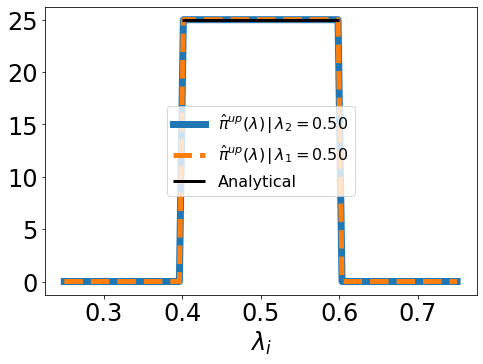

In [186]:
udpated_pdf_conditional_comparison(disc_a, num=100,
                                condition_on=0.5,
                                label='exact')

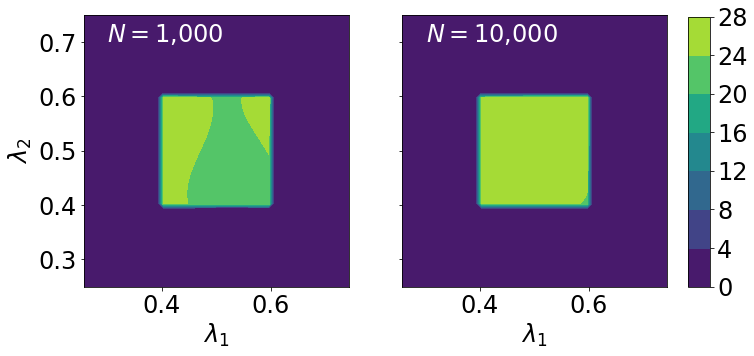

In [213]:
plot_2d_comparison(xi, yi, disc_b, disc_c, '$N=$1,000', '$N=$10,000')

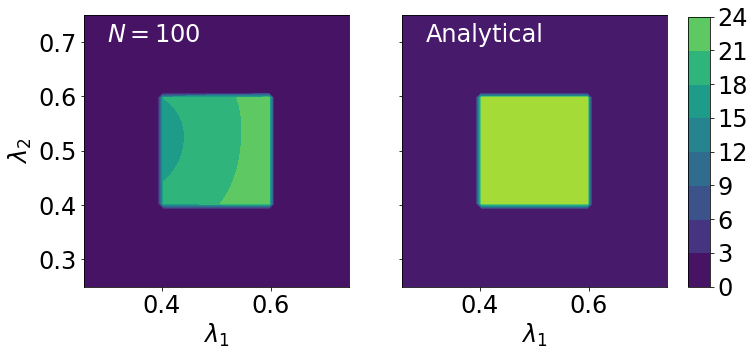

In [212]:
plot_2d_comparison(xi, yi, disc, disc_a, '$N=$100', 'Analytical')

In [19]:
# disc.get_input().estimate_volume(5E4)
# disc.set_prob_from_den()
# disc_a.set_prob_from_den()
plot_2d_comparison(xi, yi, disc, disc_a, 'Approximate-NN', 'Exact-NN')

# Accept/Reject

In [20]:
r = disc.ratio_pdf()
acc = np.random.rand(disc.check_nums()) < r/r.max()
r_a = disc_a.ratio_pdf()
acc_a = np.random.rand(disc_a.check_nums()) < r_a/r_a.max()


### plot with accepted samples

In [21]:
import seaborn

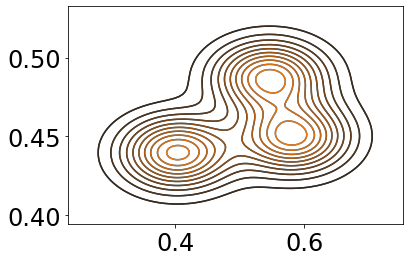

In [22]:
seaborn.kdeplot(x[acc], y[acc])
seaborn.kdeplot(x[acc_a], y[acc_a])

# Leverage BET plotting
(I personally dislike the way these plots come out and prefer `pcolormesh`)

In [23]:
disc_a.set_prob_from_den()
disc.set_prob_from_den()

In [24]:
import bet.postProcess.plotP as plotP
import glob
from IPython.display import Image

In [25]:
sigma = 0.05
dim_input = dimension
input_samples = disc_a.get_input()
folder = 'identity/'
param_ref = np.array([0.5, 0.5])
input_bins_per_dim = [25 for _ in range(dim_input)]

# calculate 2d conditional probs
(bins, conditionals2D) = plotP.calculate_2D_conditional_probs(input_samples,
                nbins = input_bins_per_dim)

# plot 2d conditionals probs
plotP.plot_2D_conditional_probs(conditionals2D, bins, input_samples, 
                filename = '%s%s_raw'%(folder, folder[:-1]), lam_ref = param_ref,
                file_extension = '.png', plot_surface=False)

# smooth 2d conditionals probs (optional)
conditionals2D = plotP.smooth_conditionals_2D(conditionals2D, bins, sigma=sigma)

# plot 2d conditionals probs
plotP.plot_2D_conditional_probs(conditionals2D, bins, input_samples, 
                filename = '%s%s_smooth'%(folder, folder[:-1]), lam_ref = param_ref,
                file_extension = '.png', plot_surface=False)

identity/identity_smooth_2D_0_1.png


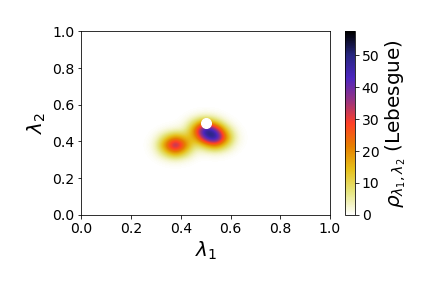

In [26]:
for f in glob.glob('%s*smooth*2D*'%(folder)):
    print(f)
    display(Image(f))

identity/identity_raw_2D_0_1.png


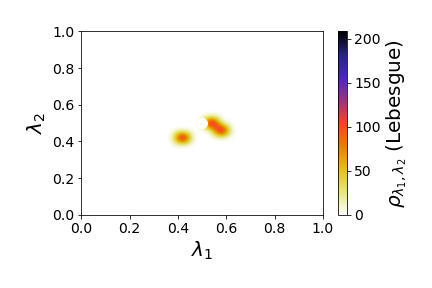

In [27]:
for f in glob.glob('%s*raw*2D*'%(folder)):
    print(f)
    display(Image(f))